In [8]:
import sys
sys.path.append("../../")

import numpy as np
from Network import NR, NC
import src.utils as utils
from matplotlib import pyplot as plt
from sklearn.neural_network import MLPClassifier


def plot_stats(conf, dataset, test, net, save=False, log=True, time=False, score=False):
    print(conf)
    net.plot_results(f"{dataset}_{test}_loss", score=False, save=save, log=log)
    if time:
        net.plot_results(f"{dataset}_{test}_loss", score=False, save=save, time=True, log=log)
    if score:
        net.plot_results(f"{dataset}_{test}_score", score=True, save=save, log=log)
        if time:
            net.plot_results(f"{dataset}_{test}_score", score=True, save=save, time=True, log=log)

    net.plot_grad(f"{dataset}_{test}", save=save)
    print(net.best_score())


def plot_comparison(x_datas, y_datas, x_label, y_label, title, loc='best', yscale='log'):
    plt.plot(x_datas[0], y_datas[0], linewidth=2., label='(A1/cm)')
    plt.yscale(yscale)
    plt.grid(True, 'major', 'both', linewidth=0.3)

    plt.plot(x_datas[1], y_datas[1], linewidth=2., label='(A1/nag)')
    plt.yscale(yscale)

    plt.plot(x_datas[2], y_datas[2], linewidth=2., label='(A2)')
    plt.yscale(yscale)

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(loc=loc, fontsize=13)
    plt.title(title)
    plt.show()
    plt.clf()
    

def report_plots(params, dataset, net_SGD, net_SGD_nest, net_Adam, score=False, time=False):

    # Conditional configuration
    x_label_time = 'Execution Time'
    x_label_ep = 'Epochs'
    curve_type = 'Objective function' if not score else 'Score'
    title = curve_type + ' comparison - ' + dataset

    train_res_SGD = net_SGD.train_scores if score else net_SGD.train_loss
    train_res_SGD_nest = net_SGD_nest.train_scores if score else net_SGD_nest.train_loss
    train_res_Adam = net_Adam.train_scores if score else net_Adam.train_loss
    x_SGD_time = net_SGD.epochs_time
    x_SGD_ep = list(range(len(train_res_SGD)))
    x_SGD_nest_time = net_SGD_nest.epochs_time
    x_SGD_nest_ep = list(range(len(train_res_SGD_nest)))
    x_Adam_time = net_Adam.epochs_time
    x_Adam_ep = list(range(len(train_res_Adam)))

    if time:
        plot_comparison([x_SGD_time, x_SGD_nest_time, x_Adam_time], 
                      [train_res_SGD, train_res_SGD_nest, train_res_Adam],
                      x_label_time, 
                      curve_type, 
                      title
                     )
    
    plot_comparison([x_SGD_ep, x_SGD_nest_ep, x_Adam_ep], 
                  [train_res_SGD, train_res_SGD_nest, train_res_Adam],
                  x_label_ep, 
                  curve_type, 
                  title
                 )
    
    plot_comparison([x_SGD_ep, x_SGD_nest_ep, x_Adam_ep], 
                  [net_SGD.grad_est_per_epoch, net_SGD_nest.grad_est_per_epoch, net_Adam.grad_est_per_epoch],
                  x_label_ep, 
                  'Gradient norm', 
                  f'Gradient norm comparison - {dataset}',
                  1
                 )

def report_stats(params, dataset, score=False, debug=False):
    if dataset == 'cup':
        nn = NR
        X_train, X_test, y_train, y_test = utils.load_CUP(datasets[dataset])
    else:
        X_train, X_test, y_train, y_test = utils.load_monk(datasets[dataset])
        nn = NC


    # --- MODEL CONFIGURATIONS ---
    param_SGD = params[dataset]['sgd'].copy()
    param_SGD_nest = params[dataset]['sgd'].copy()
    param_Adam = params[dataset]['adam'].copy()
    
    param_SGD['verbose'] = debug
    net_SGD = nn(**param_SGD)

    param_SGD_nest['verbose'] = debug
    param_SGD_nest['nesterovs_momentum'] = True
    net_SGD_nest = nn(**param_SGD_nest)

    param_Adam['verbose'] = debug
    net_Adam = nn(**param_Adam)   
    # --- MODEL CONFIGURATIONS --- 

    # Train and print best results with given configurations
    net_SGD.fit(X_train, y_train, test_data=(X_test, y_test))
    net_SGD_nest.fit(X_train, y_train, test_data=(X_test, y_test))
    net_Adam.fit(X_train, y_train, test_data=(X_test, y_test))

    print("----- SGD -----")
    print(param_SGD)
    print(net_SGD.best_score(),"\n")
    
    print("----- SGD nesterov-----")
    print(param_SGD_nest)
    print(net_SGD_nest.best_score(),"\n")

    print("----- Adam -----")
    print(param_Adam)
    print(net_Adam.best_score(),"\n")

    return net_SGD, net_SGD_nest, net_Adam


def report_gap_rate(dataset, net_SGD, net_SGD_nest, net_Adam, save=False):
    solver = '(A1/cm)'
    plot_name = f"{dataset}_{solver}"
    net_SGD.plot_gap(dataset, solver, save=save)
    net_SGD.plot_rate(plot_name, save=save)

    solver = '(A1/nag)'
    plot_name = f"{dataset}_{solver}"
    net_SGD_nest.plot_gap(dataset, solver, save=save)
    net_SGD_nest.plot_rate(plot_name, save=save)

    solver = '(A2)'
    plot_name = f"{dataset}_{solver}"
    net_Adam.plot_gap(dataset, solver, save=save)
    net_Adam.plot_rate(plot_name, save=save)


def report_gap_comp(dataset, net_SGD, net_SGD_nest, net_Adam, save=False):
    max_epochs = np.max([len(net_SGD.gap), len(net_SGD_nest.gap), len(net_Adam.gap)])
    epochs = range(max_epochs)

    plot_comparison([epochs, epochs, epochs],
        [net_SGD.gap, net_SGD_nest.gap, net_Adam.gap],
        'Epochs',
        'gap term',
        'Objective function gap comparison - ' + dataset)
    
    
def plotData(data, ylabel, title):
    plt.plot(data)
    plt.yscale('log')
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
datasets = {
    'cup': '../../data/ML-CUP20-TR.csv',
    'monk1': '../../data/monks-1',
    'monk2': '../../data/monks-2', 
    'monk3': '../../data/monks-3', 
}

params = {
    'cup': {
        'sgd': {
            'activation': 'logistic',
            'alpha': 0.3,
            'batch_size': None,
            'hidden_layer_sizes': [5, 10],
            'learning_rate_init': 0.01,
            'max_iter': 10000,
            'momentum': 0.5,
            'solver': 'sgd',
            'tol': 1e-08
        },
        'adam': {
            'activation': 'logistic',
            'alpha': 0.3,
            'batch_size': None,
            'hidden_layer_sizes': [5, 10],
            'learning_rate_init': 0.005,
            'max_iter': 10000,
            'solver': 'adam',
            'tol': 1e-08
        }
    },
    'monk1': {
        'sgd': {
            'activation': 'logistic',
            'alpha': 0.001,
            'batch_size': 10,
            'hidden_layer_sizes': [3, 5],
            'learning_rate_init': 0.005,
            'max_iter': 10000,
            'momentum': 0.9,
            'nesterovs_momentum': False,
            'solver': 'sgd',
            'tol': 1e-06
        },
        'adam': {
            'activation': 'logistic',
            'alpha': 0.001,
            'batch_size': None,
            'hidden_layer_sizes': [3,5],
            'learning_rate_init': 0.001,
            'max_iter': 10000,
            'solver': 'adam',
            'tol': 1e-6,
        }
    },
    'monk2': {
        'sgd': {
            'activation': 'logistic',
            'alpha': 0.001,
            'batch_size': 10,
            'hidden_layer_sizes': [3, 5],
            'learning_rate_init': 0.1,
            'max_iter': 10000,
            'momentum': 0.5,
            'nesterovs_momentum': False,
            'solver': 'sgd',
            'tol': 1e-06
        },
        'adam': {
            'activation': 'logistic',
            'alpha': 0.001,
            'batch_size': None,
            'hidden_layer_sizes': [3, 5],
            'learning_rate_init': 0.005,
            'max_iter': 10000,
            'solver': 'adam',
            'tol': 1e-6
        }
    },
    'monk3': {
        'sgd': {
            'activation': 'logistic',
            'alpha': 0.001,
            'batch_size': None,
            'hidden_layer_sizes': [2, 3],
            'learning_rate_init': 0.1,
            'max_iter': 10000,
            'momentum': 0.5,
            'nesterovs_momentum': False,
            'solver': 'sgd',
            'tol': 1e-06
        },
        'adam': {
            'activation': 'logistic',
            'alpha': 0.001,
            'batch_size': None,
            'hidden_layer_sizes': [2, 3],
            'learning_rate_init': 0.001,
            'max_iter': 10000,
            'solver': 'adam',
            'tol': 1e-6
        }
    }
}

# Report stats

In [4]:
plt.rcParams.update({'font.size': 15})
plt.rcParams.update({'figure.figsize': (8, 6)})

## Monk1

In [64]:
debug = False
score = False
dataset = 'monk1'
net_SGD, net_SGD_nest, net_Adam = report_stats(params, dataset, score=score, debug=debug)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:04<00:00, 2155.05it/s]

----- SGD -----
{'activation': 'logistic', 'alpha': 0.001, 'batch_size': 10, 'hidden_layer_sizes': [3, 5], 'learning_rate_init': 0.005, 'max_iter': 10000, 'momentum': 0.9, 'nesterovs_momentum': False, 'solver': 'sgd', 'tol': 1e-06, 'verbose': False}
ep: 10000   | s: [3, 5] | b: 10 | e:0.005 | alpha:0.001 | m:  0.9 | nesterovs_momentum: False
Grad: 4.99626e-03 | Loss: 1.29692e-03, 1.01545e-03 | Score:     1, 1    
ended in: 20735.718, avg per ep: 2.0735718
total update: 18051.197000000004, avg updt: 0.1504266416666667
total ff: 150000, total ff time: 4340.909000000003, avg ff: 0.028939393333333355
total bp: 130000, total bp time: 8675.268999999991, avg bp: 0.0667328384615384
total ev: 10000, total ev time: 2468.246999999995, avg ev: 0.24682469999999948

 

----- SGD nesterov-----
{'activation': 'logistic', 'alpha': 0.001, 'batch_size': 10, 'hidden_layer_sizes': [3, 5], 'learning_rate_init': 0.005, 'max_iter': 10000, 'momentum': 0.9, 'nesterovs_momentum': True, 'solver': 'sgd', 'tol': 1e

### Loss comparison

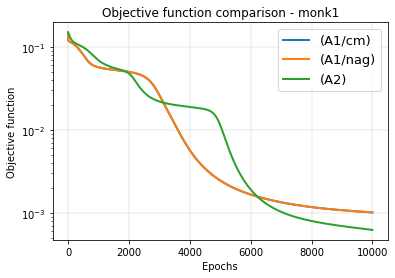

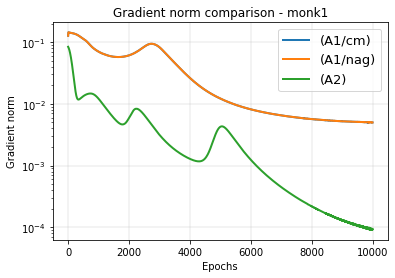

<Figure size 432x288 with 0 Axes>

In [65]:
report_plots(params, dataset, net_SGD=net_SGD, net_SGD_nest=net_SGD_nest, net_Adam=net_Adam, score=score)

### Rate and gap comparison

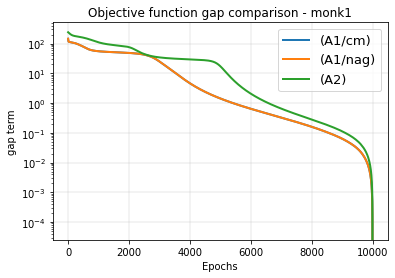

<Figure size 432x288 with 0 Axes>

In [66]:
report_gap_comp(dataset, net_SGD, net_SGD_nest, net_Adam, save=False)

## Monk2

In [67]:
debug = False
score = False
dataset = 'monk2'
net_SGD, net_SGD_nest, net_Adam = report_stats(params, dataset, score=score, debug=debug)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:05<00:00, 1831.93it/s]

----- SGD -----
{'activation': 'logistic', 'alpha': 0.001, 'batch_size': 10, 'hidden_layer_sizes': [3, 5], 'learning_rate_init': 0.1, 'max_iter': 10000, 'momentum': 0.5, 'nesterovs_momentum': False, 'solver': 'sgd', 'tol': 1e-06, 'verbose': False}
ep: 10000   | s: [3, 5] | b: 10 | e:  0.1 | alpha:0.001 | m:  0.5 | nesterovs_momentum: False
Grad: 2.54680e-03 | Loss: 6.95562e-04, 6.19129e-04 | Score:     1, 1    
ended in: 26549.373, avg per ep: 2.6549373
total update: 23693.74799999996, avg updt: 0.14808592499999976
total ff: 190000, total ff time: 5724.534999999989, avg ff: 0.03012913157894731
total bp: 170000, total bp time: 11020.49199999996, avg bp: 0.06482642352941154
total ev: 10000, total ev time: 2615.6809999999946, avg ev: 0.26156809999999947

 

----- SGD nesterov-----
{'activation': 'logistic', 'alpha': 0.001, 'batch_size': 10, 'hidden_layer_sizes': [3, 5], 'learning_rate_init': 0.1, 'max_iter': 10000, 'momentum': 0.5, 'nesterovs_momentum': True, 'solver': 'sgd', 'tol': 1e-06

### Loss comparison

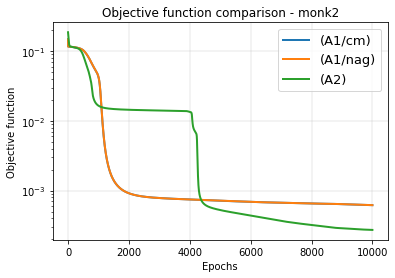

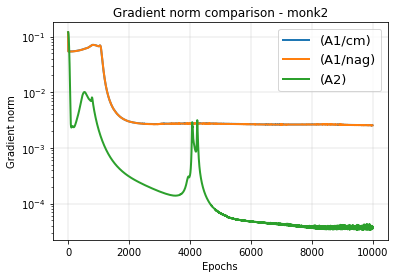

<Figure size 432x288 with 0 Axes>

In [68]:
report_plots(params, dataset, net_SGD=net_SGD, net_SGD_nest=net_SGD_nest, net_Adam=net_Adam, score=score)

### Rate and gap comparison

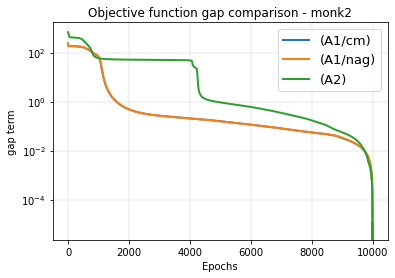

<Figure size 432x288 with 0 Axes>

In [69]:
report_gap_comp(dataset, net_SGD, net_SGD_nest, net_Adam, save=False)

## Monk3

In [70]:
debug = False
score = False
dataset = 'monk3'
net_SGD, net_SGD_nest, net_Adam = report_stats(params, dataset, score=score, debug=debug)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:04<00:00, 2354.43it/s]

----- SGD -----
{'activation': 'logistic', 'alpha': 0.001, 'batch_size': None, 'hidden_layer_sizes': [2, 3], 'learning_rate_init': 0.1, 'max_iter': 10000, 'momentum': 0.5, 'nesterovs_momentum': False, 'solver': 'sgd', 'tol': 1e-06, 'verbose': False}
ep: 10000   | s: [2, 3] | b: 122 | e:  0.1 | alpha:0.001 | m:  0.5 | nesterovs_momentum: False
Grad: 1.26598e-03 | Loss: 2.20160e-02, 2.85011e-02 | Score: 0.972, 0.934
ended in: 4042.533, avg per ep: 0.4042533
total update: 1780.6500000000044, avg updt: 0.17806500000000045
total ff: 30000, total ff time: 1242.601000000001, avg ff: 0.04142003333333337
total bp: 10000, total bp time: 860.1780000000014, avg bp: 0.08601780000000013
total ev: 10000, total ev time: 2158.4949999999944, avg ev: 0.21584949999999944

 

----- SGD nesterov-----
{'activation': 'logistic', 'alpha': 0.001, 'batch_size': None, 'hidden_layer_sizes': [2, 3], 'learning_rate_init': 0.1, 'max_iter': 10000, 'momentum': 0.5, 'nesterovs_momentum': True, 'solver': 'sgd', 'tol': 1e

### Loss comparison

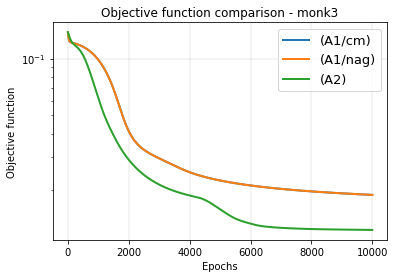

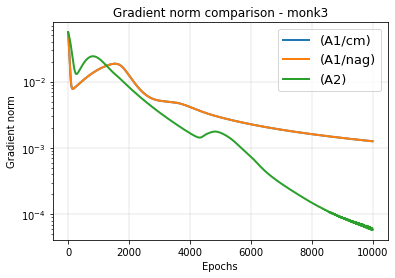

<Figure size 432x288 with 0 Axes>

In [71]:
report_plots(params, dataset, net_SGD=net_SGD, net_SGD_nest=net_SGD_nest, net_Adam=net_Adam, score=score)

### Rate and gap comparison

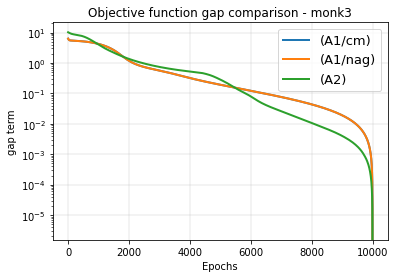

<Figure size 432x288 with 0 Axes>

In [72]:
report_gap_comp(dataset, net_SGD, net_SGD_nest, net_Adam, save=False)

## CUP

In [24]:
debug = False
score = False
dataset = 'cup'
net_SGD, net_SGD_nest, net_Adam = report_stats(params, dataset, score=score, debug=debug)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:13<00:00, 729.02it/s]

----- SGD -----
{'activation': 'logistic', 'alpha': 0.3, 'batch_size': None, 'hidden_layer_sizes': [5, 10], 'learning_rate_init': 0.0001, 'max_iter': 10000, 'momentum': 0.9, 'solver': 'sgd', 'tol': 1e-08, 'verbose': False}
ep: 10000   | s: [5, 10] | b: 1066 | e:0.0001 | alpha:  0.3 | m:  0.9 | nesterovs_momentum: False
Grad: 9.26681e-01 | Loss: 6.53089e+00, 5.42996e+00 | Score: 0.906, 0.919
ended in: 12667.0, avg per ep: 1.2667
total update: 5051.279999999996, avg updt: 0.5051279999999996
total ff: 30000, total ff time: 4125.794999999989, avg ff: 0.13752649999999964
total bp: 10000, total bp time: 2792.1799999999944, avg bp: 0.2792179999999994
total ev: 10000, total ev time: 7466.782999999975, avg ev: 0.7466782999999975

 

----- SGD nesterov-----
{'activation': 'logistic', 'alpha': 0.3, 'batch_size': None, 'hidden_layer_sizes': [5, 10], 'learning_rate_init': 0.0001, 'max_iter': 10000, 'momentum': 0.9, 'solver': 'sgd', 'tol': 1e-08, 'verbose': False, 'nesterovs_momentum': True}
ep: 100

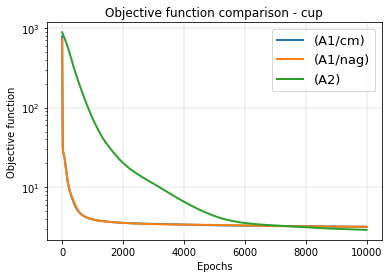

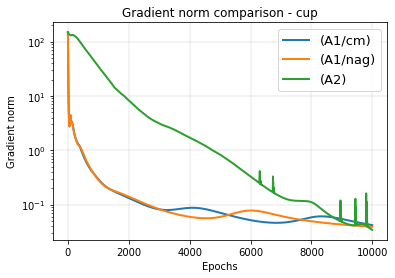

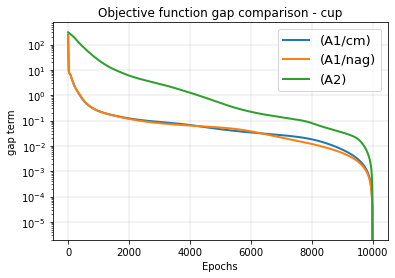

<Figure size 432x288 with 0 Axes>

In [74]:
report_plots(params, dataset, net_SGD=net_SGD, net_SGD_nest=net_SGD_nest, net_Adam=net_Adam, score=score)
report_gap_comp(dataset, net_SGD, net_SGD_nest, net_Adam, save=False)